# Car Sale Analysis

## Importing the relevant libraries

In [1]:
# For this analysis, we will need the following libraries and modules
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

## Loading the raw data

In [2]:
# Load the data from a .csv in the same folder
raw_data = pd.read_csv('1.04. Real-life example.csv')

# Explore the top 5 rows of the df
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


We would like to predict the price of a used car depending on its specifications. Potential regressors in this data are:
<br>
<br>
1) Brand: A BMW is generally more expensive than a Toyota.
<br>
2) Mileage: The more a car is driven, the cheaper it should be.
<br>
3) Engine Volume: Sports car have larger engines than economy cars.
<br>
4) Year of Production: The older the car, the cheaper it is, with the exception of vintage vehicles.
<br>
<br>
The rest are categorical variables which we will deal with on a case-by-case basis.

## Preprocessing

### Exploring the descriptive statistics of the variables

In [3]:
# By default, only descriptives for the numerical variables would be shown
# To include the categorical ones, we should specify this with an argument
raw_data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


- The categorical variables don't have some types of numerical descriptives
- The numerical variables don't have some types of categorical descriptives
- Each variable has a different number of observations, implying that there are some missing values.
- There are more than 300 models of cars, meaning we would have more than 300 dummy variables, which would be hard to implement in a regression. Also, a lot of the information from 'Model' could be engineered from 'Brand', 'Year', and 'EngineV', so we won't be losing too much variability. Therefore, we can drop 'Model'.
- Registration has almost all 'yes' entries, so this variable probably won't be very useful

### Determining the variables of interest

In [4]:
# Drop 'Registration' column from dataset
#data = raw_data.drop(['Registration'],axis=1)
#data.describe(include='all')
data = raw_data

### Dealing with missing values

In [5]:
# data.isnull() # shows a df with the information whether a data point is null 
# Since True = the data point is missing, while False = the data point is not missing, we can sum them
# This will give us the total number of missing values feature-wise
data.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
Model             0
dtype: int64

In [6]:
# Drop all missing values
# This is not always recommended, however, when we remove less than 5% of the data, it is okay
data_no_mv = data.dropna(axis=0)

In [7]:
# Check the descriptives without the missing values
data_no_mv.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4025,4025.000000,4025,4025.000000,4025.000000,4025,4025,4025.000000,4025
unique,7,NaN,6,NaN,NaN,4,2,NaN,306
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,880,NaN,1534,NaN,NaN,1861,3654,NaN,188
mean,NaN,19552.308065,NaN,163.572174,2.764586,NaN,NaN,2006.379627,NaN
std,NaN,25815.734988,NaN,103.394703,4.935941,NaN,NaN,6.695595,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,90.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21900.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


Notice the min and max values with respect to the mean and the quartiles for each variable. Namely, the max values for Price, Mileage, and EngineV are very high, and the min value for Year is very low compared to the rest of the values.

### Exploring the PDFs
- The probability distribution function (PDF) of a variable will show us how that variable is distributed 
- This will make it very easy to spot anomalies, such as outliers
- The PDF is often the basis on which we decide whether we want to transform a feature

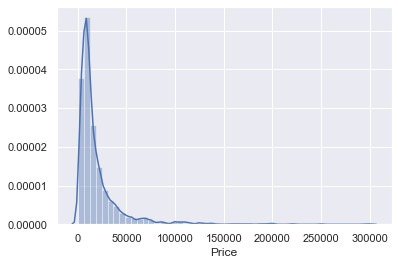

In [8]:
sns.distplot(data_no_mv['Price'])

- For optimal results, we would be looking for a normal distribution.
- Price, however, has an exponential one, which will surely be a problem for our regression.
- Price has 75% of values below or equal to 21,900 but the max value is 300,000, so obviously there are some outliers present.

### Dealing with outliers

- We can deal with the problem easily by removing 0.5% or 1% of the problematic samples
- Here, the outliers are situated around the higher prices (right side of the graph)
- Logic should also be applied
- This is a dataset about used cars, therefore one can imagine how \\$300,000 is an excessive price
- Outliers are a big issue for OLS, thus we must deal with them in some way


In [9]:
# Declare a variable that will be equal to the 98th percentile of the 'Price' variable
q = data_no_mv['Price'].quantile(0.98)
# Then we can create a new df, with the condition that all prices must be below the 98 percentile of 'Price'
data_1 = data_no_mv[data_no_mv['Price']<q]
# In this way we have essentially removed the top 2% of the data about 'Price'
data_1.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,3943,3943.000000,3943,3943.000000,3943.000000,3943,3943,3943.000000,3943
unique,7,NaN,6,NaN,NaN,4,2,NaN,300
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,880,NaN,1515,NaN,NaN,1818,3572,NaN,188
mean,NaN,16840.689820,NaN,166.739538,2.738415,NaN,NaN,2006.197312,NaN
std,NaN,16332.966734,NaN,102.042365,4.980975,NaN,NaN,6.640292,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6900.000000,NaN,95.000000,1.800000,NaN,NaN,2002.000000,NaN
50%,NaN,11250.000000,NaN,160.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,20800.000000,NaN,230.000000,3.000000,NaN,NaN,2011.000000,NaN


- The max Price is now ~103,000, which is still far away from the mean, but acceptably closer.

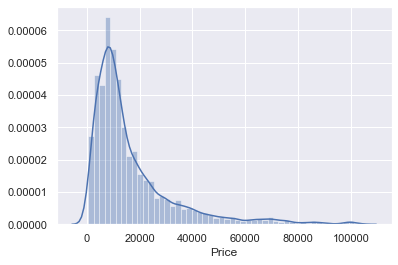

In [10]:
# We can check the PDF once again to ensure that the result is still distributed in the same way overall
sns.distplot(data_1['Price'])

- There are much fewer outliers

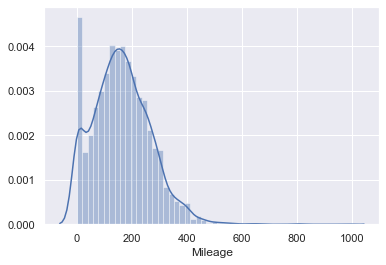

In [11]:
# We can treat the other numerical variables in a similar way
sns.distplot(data_no_mv['Mileage'])

In [12]:
q = data_1['Mileage'].quantile(0.99)
data_2 = data_1[data_1['Mileage']<q]

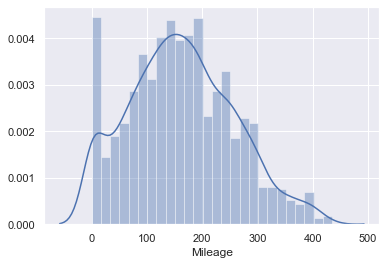

In [13]:
sns.distplot(data_2['Mileage'])

- At this point, this plot seems to have a pretty normal distribution

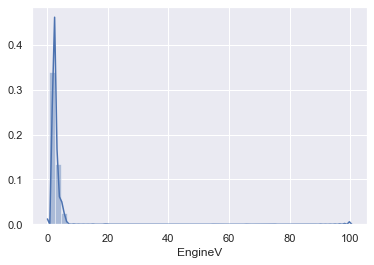

In [14]:
sns.distplot(data_no_mv['EngineV'])

- The situation with engine volume is very strange
- In such cases it makes sense to manually check what may be causing the problem
- In our case the issue comes from the fact that most missing values are indicated with 99.99 or 99
- There are also some incorrect entries like 75
- A simple Google search can indicate the natural domain of this variable
- Car engine volumes are usually (always?) below 6.5
- This is a prime example of the fact that a domain expert (a person working in the car industry) may find it much easier to determine problems with the data than an outsider

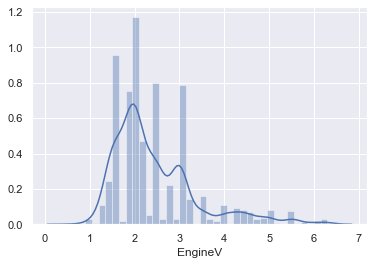

In [15]:
data_3 = data_2[data_2['EngineV']<6.5]
sns.distplot(data_3['EngineV'])

- Following this graph, we realize we can actually treat EngineV as a categorical variable
- Even so, we won't, but that could be something else to try

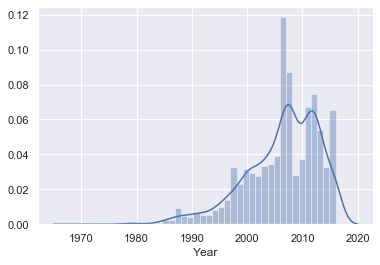

In [16]:
sns.distplot(data_no_mv['Year'])

- Finally, the situation with 'Year' is similar to 'Price' and 'Mileage'
- However, the outliers are on the low end (a.k.a some vintage cars)

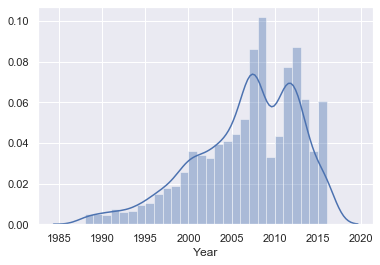

In [17]:
# Remove outliers because vintage cars are not representative of our model
q = data_3['Year'].quantile(0.01)
data_4 = data_3[data_3['Year']>q]
sns.distplot(data_4['Year'])

In [18]:
# Reset the index and drop the column containing the old index
data_cleaned = data_4.reset_index(drop=True)

In [19]:
# Let's see what's left
data_cleaned.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,3826,3826.000000,3826,3826.000000,3826.000000,3826,3826,3826.000000,3826
unique,7,NaN,6,NaN,NaN,4,2,NaN,289
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,848,NaN,1454,NaN,NaN,1772,3464,NaN,181
mean,NaN,17171.386333,NaN,162.166231,2.441777,NaN,NaN,2006.615787,NaN
std,NaN,16396.219278,NaN,94.831169,0.947973,NaN,NaN,6.067533,NaN
min,NaN,800.000000,NaN,0.000000,0.600000,NaN,NaN,1988.000000,NaN
25%,NaN,7200.000000,NaN,94.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,159.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21000.000000,NaN,227.000000,3.000000,NaN,NaN,2011.000000,NaN


- Overall, we've deleted ~100 observations that proved to be problematic.

## Checking the OLS assumptions

- The categorical variables will be included as dummies, so we don't need to worry about them when checking the assumptions
- The continuous variables (Price, Year, EngineV, Mileage) are those that are likely to be more challenging and cause us more problems

### Linearity

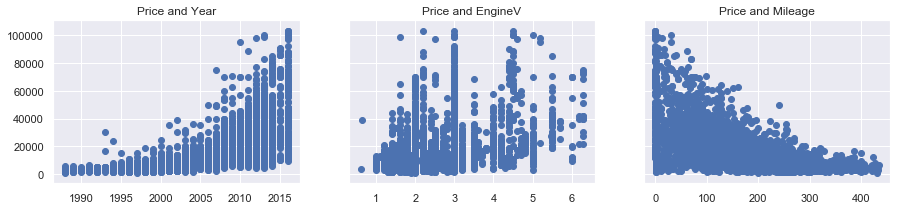

In [20]:
# We could simply use plt.scatter() for each of Year, EngineV, and Mileage
# But since Price is the 'y' axis of all the plots, it made sense to plot them side-by-side (so we can compare them)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3)) #sharey -> share 'Price' as y
ax1.scatter(data_cleaned['Year'],data_cleaned['Price'])
ax1.set_title('Price and Year')
ax2.scatter(data_cleaned['EngineV'],data_cleaned['Price'])
ax2.set_title('Price and EngineV')
ax3.scatter(data_cleaned['Mileage'],data_cleaned['Price'])
ax3.set_title('Price and Mileage')

plt.show()

- These patterns are not linear so we should not run a linear regression without transforming one or more variables.

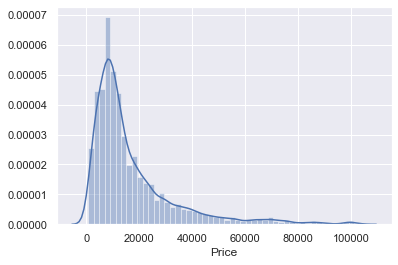

In [21]:
sns.distplot(data_cleaned['Price'])

- From the subplots and the PDF of price, we can easily determine that 'Price' is exponentially distributed
- Therefore, it's relationships with the other normally distributed features is not linear but rather quite exponential
- A good transformation in that case is a log transformation

### Relaxing the assumptions

In [22]:
# Transform 'Price' with a log transformation
log_price = np.log(data_cleaned['Price'])

# Then add it to our data frame
data_cleaned['log_price'] = log_price
data_cleaned

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,log_price
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320,8.342840
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500,9.495519
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7,10.043249
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4,9.814656
...,...,...,...,...,...,...,...,...,...,...
3821,Renault,6800.0,sedan,152,1.6,Petrol,yes,2007,Megane,8.824678
3822,Volkswagen,11500.0,van,163,2.5,Diesel,yes,2008,T5 (Transporter),9.350102
3823,Toyota,17900.0,sedan,35,1.6,Petrol,yes,2014,Corolla,9.792556
3824,BMW,6500.0,sedan,1,3.5,Petrol,yes,1999,535,8.779557


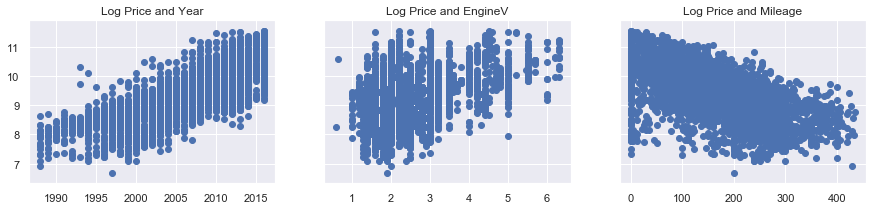

In [23]:
# Let's check the three scatters once again
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3))
ax1.scatter(data_cleaned['Year'],data_cleaned['log_price'])
ax1.set_title('Log Price and Year')
ax2.scatter(data_cleaned['EngineV'],data_cleaned['log_price'])
ax2.set_title('Log Price and EngineV')
ax3.scatter(data_cleaned['Mileage'],data_cleaned['log_price'])
ax3.set_title('Log Price and Mileage')

plt.show()

- The relationships show a clear linear relationship
- This is some good linear regression material
- Alternatively we could have transformed each of the independent variables

In [24]:
# Since we will be using the log price variable, we can drop the old 'Price' one
data_cleaned = data_cleaned.drop(['Price'],axis=1)

Now we will deal with the rest of the assumptions:
<br>
- No Endogeneity: No correlation between residuals and independent variables (we'll discuss the residuals after the regression is created)
- Normality and Homoscedasticity:
    - Normality: assumed for a big sample following the Central Limit Theorem
    - Zero mean of the distribution of errors: accomplished through including the intercept in the regression
    - Homoscedasticity: generally holds, as we can see in the above graphs (already implemented log transformation)
- No Autocorrelation: Our observations are not coming from time-series or panel data, they are simply a snapshot of the current situation of a second-hand car sales website - each row comes from a different customer who is willing to sell their car through the platform. Logically, there is no reason for the observations to be dependent on each other, so we are safe:
- Multicolinearity: Since an older car would have more mileage, there is grounds to check for multicolinearity (i.e. Year and Mileage)

### Multicollinearity

In [25]:
# Let's quickly see the columns of our data frame
data_cleaned.columns.values

array(['Brand', 'Body', 'Mileage', 'EngineV', 'Engine Type',
       'Registration', 'Year', 'Model', 'log_price'], dtype=object)

- sklearn does not have a built-in way to check for multicollinearity
- Here's the relevant module
- Full documentation: http://www.statsmodels.org/dev/_modules/statsmodels/stats/outliers_influence.html#variance_inflation_factor

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# To make this as easy as possible to use, we declare a variable where we put
# all features where we want to check for multicollinearity
# since our categorical data is not yet preprocessed, we will only take the numerical ones
variables = data_cleaned[['Mileage','Year','EngineV']]

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = variables.columns

In [27]:
# Let's explore the result
vif

,VIF,Features
0,3.899033,Mileage
1,10.307533,Year
2,7.637076,EngineV


- Since Year has the highest VIF, I will remove it from the model
- This will drive the VIF of other variables down
- So even if EngineV seems with a high VIF, too, once 'Year' is gone that will no longer be the case

In [28]:
data_no_multicollinearity = data_cleaned.drop(['Year'],axis=1)

## Create dummy variables

- To include the categorical data in the regression, let's create dummies
- There is a very convenient method called: 'get_dummies' which does that seemlessly for all categorical variables in the dataset
- It is extremely important that we drop one of the dummies, alternatively we will introduce multicollinearity
    - If we have N categories for a feature, we have to create N-1 dummies, otherwise the Nth category could be perfectly predicted by the other N-1 dummies.

In [29]:
data_with_dummies = pd.get_dummies(data_no_multicollinearity, drop_first=True)
data_with_dummies.head()

,Mileage,EngineV,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,...,Model_Vito,Model_X1,Model_X3,Model_X5,Model_X5 M,Model_X6,Model_X6 M,Model_Yaris,Model_Z3,Model_Z4
0,277,2.0,8.342840,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,427,2.9,8.974618,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,358,5.0,9.495519,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,240,4.2,10.043249,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,120,2.0,9.814656,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Rearrange a bit
- To make our data frame more organized, we prefer to place the dependent variable in the beginning of the df
- Since each problem is different, that must be done manually
- We can display all possible features and then choose the desired order

In [30]:
data_with_dummies.columns.values

array(['Mileage', 'EngineV', 'log_price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes',
       'Model_100', 'Model_11', 'Model_116', 'Model_118', 'Model_120',
       'Model_19', 'Model_190', 'Model_200', 'Model_210', 'Model_220',
       'Model_230', 'Model_25', 'Model_250', 'Model_300', 'Model_316',
       'Model_318', 'Model_320', 'Model_323', 'Model_325', 'Model_328',
       'Model_330', 'Model_335', 'Model_4 Series Gran Coupe', 'Model_428',
       'Model_4Runner', 'Model_5 Series', 'Model_5 Series GT',
       'Model_520', 'Model_523', 'Model_524', 'Model_525', 'Model_528',
       'Model_530', 'Model_535', 'Model_540', 'Model_545', 'Model_550',
       'Model_6 Series Gran Coupe', 'Model_630', 'Model_640', 'Model_645',
       'Model_650', 'Model_73

- To make the code a bit more parametrized, let's declare a new variable that will contain the preferred order
- Conventionally, the most intuitive order is: dependent variable, indepedendent numerical variables, dummies

In [31]:
cols = ['log_price', 'Mileage', 'EngineV', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes', 'Model_100', 'Model_11', 'Model_116', 'Model_118', 'Model_120',
       'Model_19', 'Model_190', 'Model_200', 'Model_210', 'Model_220',
       'Model_230', 'Model_25', 'Model_250', 'Model_300', 'Model_316',
       'Model_318', 'Model_320', 'Model_323', 'Model_325', 'Model_328',
       'Model_330', 'Model_335', 'Model_4 Series Gran Coupe', 'Model_428',
       'Model_4Runner', 'Model_5 Series', 'Model_5 Series GT',
       'Model_520', 'Model_523', 'Model_524', 'Model_525', 'Model_528',
       'Model_530', 'Model_535', 'Model_540', 'Model_545', 'Model_550',
       'Model_6 Series Gran Coupe', 'Model_630', 'Model_640', 'Model_645',
       'Model_650', 'Model_730', 'Model_735', 'Model_740', 'Model_745',
       'Model_750', 'Model_760', 'Model_80', 'Model_9', 'Model_90',
       'Model_A 140', 'Model_A 150', 'Model_A 170', 'Model_A 180',
       'Model_A1', 'Model_A3', 'Model_A4', 'Model_A4 Allroad', 'Model_A5',
       'Model_A6', 'Model_A6 Allroad', 'Model_A7', 'Model_A8',
       'Model_ASX', 'Model_Amarok', 'Model_Auris', 'Model_Avalon',
       'Model_Avensis', 'Model_Aygo', 'Model_B 170', 'Model_B 180',
       'Model_B 200', 'Model_Beetle', 'Model_Bora', 'Model_C-Class',
       'Model_CL 180', 'Model_CL 500', 'Model_CL 55 AMG', 'Model_CL 550',
       'Model_CL 63 AMG', 'Model_CLA 200', 'Model_CLA 220',
       'Model_CLA-Class', 'Model_CLC 180', 'Model_CLC 200',
       'Model_CLK 200', 'Model_CLK 220', 'Model_CLK 230', 'Model_CLK 240',
       'Model_CLK 280', 'Model_CLK 320', 'Model_CLK 430', 'Model_CLS 350',
       'Model_CLS 400', 'Model_CLS 500', 'Model_CLS 63 AMG',
       'Model_Caddy', 'Model_Camry', 'Model_Captur', 'Model_Caravelle',
       'Model_Carina', 'Model_Carisma', 'Model_Celica', 'Model_Clio',
       'Model_Colt', 'Model_Corolla', 'Model_Corolla Verso',
       'Model_Cross Touran', 'Model_Dokker', 'Model_Duster',
       'Model_E-Class', 'Model_Eclipse', 'Model_Eos', 'Model_Espace',
       'Model_FJ Cruiser', 'Model_Fluence', 'Model_Fortuner',
       'Model_G 320', 'Model_G 500', 'Model_G 55 AMG', 'Model_G 63 AMG',
       'Model_GL 320', 'Model_GL 350', 'Model_GL 420', 'Model_GL 450',
       'Model_GL 500', 'Model_GL 550', 'Model_GLC-Class',
       'Model_GLE-Class', 'Model_GLK 220', 'Model_GLK 300',
       'Model_GLS 350', 'Model_Galant', 'Model_Golf GTI', 'Model_Golf II',
       'Model_Golf III', 'Model_Golf IV', 'Model_Golf Plus',
       'Model_Golf V', 'Model_Golf VI', 'Model_Golf VII',
       'Model_Golf Variant', 'Model_Grand Scenic', 'Model_Grandis',
       'Model_Hiace', 'Model_Highlander', 'Model_Hilux', 'Model_I3',
       'Model_IQ', 'Model_Jetta', 'Model_Kangoo', 'Model_Koleos',
       'Model_L 200', 'Model_LT', 'Model_Laguna', 'Model_Lancer',
       'Model_Lancer Evolution', 'Model_Lancer X',
       'Model_Lancer X Sportback', 'Model_Land Cruiser 100',
       'Model_Land Cruiser 105', 'Model_Land Cruiser 200',
       'Model_Land Cruiser 76', 'Model_Land Cruiser 80',
       'Model_Land Cruiser Prado', 'Model_Latitude', 'Model_Logan',
       'Model_Lupo', 'Model_M5', 'Model_M6', 'Model_MB', 'Model_ML 250',
       'Model_ML 270', 'Model_ML 280', 'Model_ML 320', 'Model_ML 350',
       'Model_ML 400', 'Model_ML 430', 'Model_ML 500', 'Model_ML 550',
       'Model_ML 63 AMG', 'Model_Master', 'Model_Matrix', 'Model_Megane',
       'Model_Modus', 'Model_Multivan', 'Model_New Beetle',
       'Model_Outlander', 'Model_Outlander XL', 'Model_Pajero',
       'Model_Pajero Pinin', 'Model_Pajero Sport', 'Model_Pajero Wagon',
       'Model_Passat B3', 'Model_Passat B4', 'Model_Passat B5',
       'Model_Passat B6', 'Model_Passat B7', 'Model_Passat B8',
       'Model_Passat CC', 'Model_Phaeton', 'Model_Pointer', 'Model_Polo',
       'Model_Previa', 'Model_Prius', 'Model_Q3', 'Model_Q5', 'Model_Q7',
       'Model_R 320', 'Model_R8', 'Model_Rav 4', 'Model_S 140',
       'Model_S 250', 'Model_S 300', 'Model_S 320', 'Model_S 350',
       'Model_S 400', 'Model_S 430', 'Model_S 500', 'Model_S 550',
       'Model_S 600', 'Model_S 63 AMG', 'Model_S 65 AMG', 'Model_S4',
       'Model_S5', 'Model_S8', 'Model_SL 500 (550)', 'Model_SL 55 AMG',
       'Model_SLK 200', 'Model_SLK 350', 'Model_Sandero',
       'Model_Sandero StepWay', 'Model_Scenic', 'Model_Scion',
       'Model_Scirocco', 'Model_Sequoia', 'Model_Sharan', 'Model_Sienna',
       'Model_Smart', 'Model_Space Star', 'Model_Space Wagon',
       'Model_Sprinter 208', 'Model_Sprinter 210', 'Model_Sprinter 211',
       'Model_Sprinter 212', 'Model_Sprinter 213', 'Model_Sprinter 311',
       'Model_Sprinter 312', 'Model_Sprinter 313', 'Model_Sprinter 315',
       'Model_Sprinter 316', 'Model_Sprinter 318', 'Model_Sprinter 319',
       'Model_Symbol', 'Model_Syncro', 'Model_T3 (Transporter)',
       'Model_T4 (Transporter)', 'Model_T4 (Transporter) ',
       'Model_T5 (Transporter)', 'Model_T5 (Transporter) ',
       'Model_T6 (Transporter)', 'Model_T6 (Transporter) ', 'Model_TT',
       'Model_Tacoma', 'Model_Tiguan', 'Model_Touareg', 'Model_Touran',
       'Model_Trafic', 'Model_Tundra', 'Model_Up', 'Model_V 250',
       'Model_Vaneo', 'Model_Vento', 'Model_Venza', 'Model_Viano',
       'Model_Virage', 'Model_Vista', 'Model_Vito', 'Model_X1',
       'Model_X3', 'Model_X5', 'Model_X5 M', 'Model_X6', 'Model_X6 M',
       'Model_Yaris', 'Model_Z3', 'Model_Z4']

In [32]:
# To implement the reordering, we will create a new df, which is equal to the old one but with the new order of features
data_preprocessed = data_with_dummies[cols]
data_preprocessed.head()

,log_price,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,...,Model_Vito,Model_X1,Model_X3,Model_X5,Model_X5 M,Model_X6,Model_X6 M,Model_Yaris,Model_Z3,Model_Z4
0,8.342840,277,2.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8.974618,427,2.9,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.495519,358,5.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10.043249,240,4.2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.814656,120,2.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Linear regression model

### Declare the inputs and the targets

In [33]:
# The target(s) (dependent variable) is 'log price'
targets = data_preprocessed['log_price']

# The inputs are everything BUT the dependent variable, so we can simply drop it
inputs = data_preprocessed.drop(['log_price'],axis=1)

### Scale the data

In [34]:
# Import the scaling module
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()
# Fit the inputs (calculate the mean and standard deviation feature-wise)
scaler.fit(inputs)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [35]:
# Scale the features and store them in a new variable (the actual scaling procedure)
inputs_scaled = scaler.transform(inputs)

- Dummy variables are also being standardized here, so they lose all of their dummy meaning, but this should not have a large effect on the model

### Train Test Split

In [36]:
# Import the module for the split
from sklearn.model_selection import train_test_split

# Split the variables with an 80-20 split and some random state
# To have the same split each time, use random_state = 365
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

### Create the regression

In [37]:
# Create a linear regression object
reg = LinearRegression()
# Fit the regression with the scaled TRAIN inputs and targets
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

- This is actually a log-linear regression as the dependent variables is the log of 'Price'
- We want to check the regression by plotting the predicted values against the observed values

In [38]:
# Let's check the outputs of the regression
# I'll store them in y_hat as this is the 'theoretical' name of the predictions
y_hat = reg.predict(x_train)

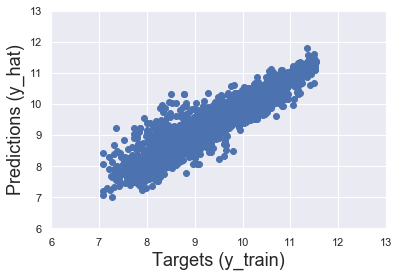

In [39]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_train, y_hat)
# Let's also name the axes
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
# We need to make sure the scales of the x-axis and the y-axis are the same
# Otherwise we wouldn't be able to interpret the '45-degree line'
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

- Our result is not perfect but definitely not random
- The points are situated around the 45-degree line, so our model has passed this first check

Text(0.5, 1.0, 'Residuals PDF')

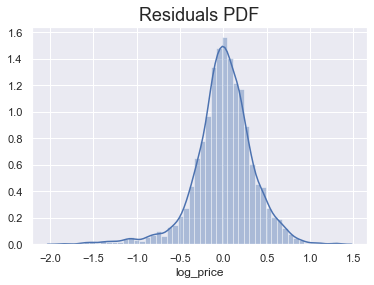

In [40]:
# Another useful check of our model is a residual plot
# Residuals = targets - predictions
# We can plot the PDF of the residuals and check for anomalies
sns.distplot(y_train - y_hat)

# Include a title
plt.title("Residuals PDF", size=18)

- In the best case scenario this plot should be normally distributed
- This is because our regression assumptions said that our errors should be normally distributed with a mean of 0 --> since the residutals are the estimates of the errors, we would expect the same
- In our case we notice that is a much longer tail on the left side, so there are many negative residuals (far away from the mean)
- Given the definition of the residuals (y_train - y_hat), negative values imply that y_hat (predictions) are much higher than y_train (the targets) --> some of the predictions tend to overestimate the targets but rarely underestimate the targets
- This is food for thought to improve our model

In [41]:
# Find the R-squared of the model
r2 = reg.score(x_train,y_train)
r2

0.8347161853185299

- The appropriate measure to use here is the adjusted R-squared 

In [42]:
# Number of observations is the shape along axis 0
n = x_train.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = x_train.shape[1]

# We find the Adjusted R-squared using the formula
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
adjusted_r2

0.8164113329300592

- Since the adjusted R^2 was a bit lower than the regular R^2, showing that at least one of the variables included is not increasing the explanatory power of the regression
- We can use feature selection to identify that variable, remove it, and further simplify our model

### Feature Selection

In [60]:
from sklearn.feature_selection import f_regression

In [61]:
f_regression(x_train, y_train)

(array([1.76068144e+03, 6.23344807e+02, 1.45893327e+01, 2.59454872e+01,
        1.76510386e+01, 1.18643960e+02, 8.39780982e+01, 3.13007519e+01,
        5.92802666e+01, 8.38777989e+00, 5.79453632e+01, 1.03804394e+02,
        4.29209798e+01, 1.83643828e+01, 1.23316590e+00, 9.30208253e+00,
        9.08970229e+02, 2.36498989e+01, 1.17908948e-14, 3.22393208e-01,
        1.99821289e-03, 2.07573186e+00, 6.76666574e+00, 1.01431727e+01,
        3.71523133e+00, 2.61334565e+00, 5.19098970e-01, 4.18362006e+00,
        1.17908948e-14, 1.17908948e-14, 1.17225278e-14, 5.57624782e+00,
        2.30302970e+01, 1.87914562e+01, 5.30811184e-01, 2.28915986e-02,
        6.28764284e-01, 1.60638823e+00, 8.46476912e-01, 1.17225278e-14,
        1.17225278e-14, 2.22227996e+00, 2.82353443e+00, 5.61381468e+00,
        5.71612162e-01, 2.19559098e+00, 1.17225278e-14, 5.00342254e+01,
        3.71916875e+00, 3.70137924e+00, 2.89878008e+00, 1.12737963e+00,
        2.92506588e-01, 9.56094613e+00, 5.43503573e+00, 5.688134

In [62]:
p_values = f_regression(x_train, y_train)[1].round(3)
p_values

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.004, 0.   , 0.   , 0.   , 0.   , 0.267, 0.002, 0.   , 0.   ,
       1.   , 0.57 , 0.964, 0.15 , 0.009, 0.001, 0.054, 0.106, 0.471,
       0.041, 1.   , 1.   , 1.   , 0.018, 0.   , 0.   , 0.466, 0.88 ,
       0.428, 0.205, 0.358, 1.   , 1.   , 0.136, 0.093, 0.018, 0.45 ,
       0.139, 1.   , 0.   , 0.054, 0.054, 0.089, 0.288, 0.589, 0.002,
       0.02 , 0.451, 0.   , 0.297, 0.467, 0.734, 0.421, 0.596, 0.581,
       0.   , 0.538, 0.164, 0.007, 1.   , 0.076, 0.734, 0.   , 0.302,
       0.641, 0.716, 0.   , 0.07 , 0.   , 0.   , 0.514, 0.002, 0.057,
       0.323, 0.311, 0.768, 0.77 , 0.501, 0.537, 0.937, 0.211, 0.786,
       0.15 , 0.035, 0.223, 0.02 , 0.338, 0.025, 0.202, 0.002, 0.042,
       0.136, 0.165, 0.588, 0.624, 0.058, 0.533, 0.1  , 0.765, 0.467,
       0.815, 1.   , 0.128, 0.012, 0.008, 0.015, 0.001, 0.01 , 0.42 ,
       0.395, 0.018, 0.002, 0.548, 0.029, 0.006, 0.006, 0.588, 0.986,
       0.644, 0.621,

- If a variable as a p-value > 0.05, we can disregard it, because that variable is redundant (not relevant), but we still don't necessarily know how useful/important that variable is

### Finding the weights and bias

In [43]:
# Obtain the bias (intercept) of the regression
reg.intercept_

295271601566.04913

In [44]:
# Obtain the weights (coefficients) of the regression
reg.coef_

array([-3.42013244e-01,  4.71096963e-02, -2.73881723e+12,  1.55135632e+12,
        2.14702126e+12, -1.05825320e+11, -3.81614744e+12,  4.61157477e+12,
       -6.64366447e-02, -2.47802734e-02, -9.10339355e-02, -7.34863281e-02,
       -5.18798828e-02, -9.10644531e-02, -2.86865234e-02, -1.19873047e-01,
        3.11401367e-01, -4.64764931e+11,  1.12852481e+13,  3.52325439e-02,
        4.17938232e-02, -8.01467896e-03, -1.62354331e+11, -3.68549829e+11,
       -3.68549829e+11, -2.60672259e+11, -2.60672259e+11, -2.60672259e+11,
        8.03730594e+12,  3.00664832e+12,  8.80732154e+12,  1.95312500e-02,
        5.31005859e-02,  1.06018066e-01,  1.80358887e-02,  1.82495117e-02,
        2.32086182e-02,  4.77905273e-02,  3.47900391e-02,  1.16416367e+13,
        5.72933076e+12,  6.34224883e+10,  1.84020996e-02,  4.48608398e-02,
        1.48162842e-01,  5.04455566e-02, -1.41364946e+13,  6.83898926e-02,
        5.41381836e-02,  1.10443115e-01,  7.21130371e-02,  2.02636719e-02,
        2.65655518e-02,  

- Note that they are barely interpretable if at all

In [64]:
# Create a regression summary where we can compare them with one-another
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary['p-values'] = p_values
reg_summary

,Features,Weights,p-values
0,Mileage,-0.34,0.00
1,EngineV,0.05,0.00
2,Brand_BMW,-2738817232235.43,0.00
3,Brand_Mercedes-Benz,1551356317399.53,0.00
4,Brand_Mitsubishi,2147021258533.68,0.00
5,Brand_Renault,-105825320085.92,0.00
6,Brand_Toyota,-3816147441217.25,0.00
7,Brand_Volkswagen,4611574773601.37,0.00
8,Body_hatch,-0.07,0.00
9,Body_other,-0.02,0.00


- The bigger the weight, the bigger the impact
- Mileage seems to have the largest impact, which makes sense
- All of our numerical variables have p-values = 0 so they are relevant and should be kept in the model
<br>
<br>
Continuous variables:
- Positive weight: positive correlation between log_price and feature
- Negative weight: negative correlation between log_price and feature

In [46]:
# Check the different categories in the 'Brand' variable
data_cleaned['Brand'].unique()

array(['BMW', 'Mercedes-Benz', 'Audi', 'Toyota', 'Renault', 'Volkswagen',
       'Mitsubishi'], dtype=object)

- In this way we can see which 'Brand' is actually the benchmark
- After looking at the weights table, we can see that Audi was the dropped brand 
- Therefore, when all other dummies are 0, Audi is 1
- Therefore, Audi is the benchmark
<br>
<br>
Dummy variables:
- Positive weight: respective category (Brand) is more expensive than the benchmark (Audi)
- Negative weight: respective category (Brand) is less expensive than the benchmark (Audi)
<br>
<br>
- For example) BMW is more expensive than Audi but Mitsubishi is less expensive than Audi
-Clearly, we can see that we cannot compare continuous variables and dummy variables, as the dummy variables can only be compared to their respective benchmarks

In [47]:
# Check the different categories in the 'Body' variable
data_cleaned['Body'].unique()

array(['sedan', 'van', 'crossover', 'vagon', 'other', 'hatch'],
      dtype=object)

- 'crossover' was the dropped brand and therefore the benchmark
- It seems that, generally, crossover is the most expensive type of body, which makes sense

In [48]:
# Check the different categories in the 'Engine Type
data_cleaned['Engine Type'].unique()

array(['Petrol', 'Diesel', 'Gas', 'Other'], dtype=object)

- 'Diesel' was the dropped brand and therefore the benchmark
- It seems that, generally, diesel is the most expensive type of engine, which makes sense

## Testing
- Now that we have trained and fine-tuned our model, we can proceed to testing it
- Our test inputs are 'x_test', while the outputs: 'y_test' , which the algorithm has not seen yet
- We will feed these inputs and find the predictions
- If the predictions are far off, we will know that our model overfitted

In [49]:
# Find the predicted values using inputs from the test data
y_hat_test = reg.predict(x_test)

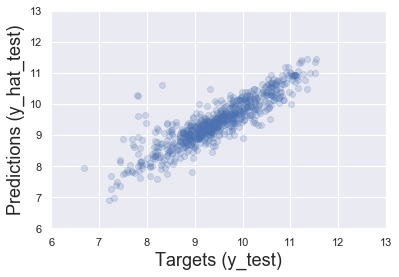

In [50]:
# Create a scatter plot with the test targets and the test predictions
# Including the argument 'alpha' introduces proportaional opacity to the graph
# The more saturated the color, the higher the concentration of points (like a heat map
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

- Overall, the points seem to hover around the 45-degree line, which is good
- For higher prices, we have a higher concentration of values around the 45-degree line. Therefore, our model is very good at predicting higher prices.
- However, for lower prices, the values are much more scattered, meaning that we are not getting as many of the prices right. 
- From the opacity, we can see that most of the points are indeed very close to the 45-degree line

In [51]:
# Finally, let's manually check these predictions
# To obtain the actual prices, we take the exponential of the log_price
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

/Users/Sujay/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


,Prediction
0,18159.439748
1,3061.537021
2,13747.681742
3,12996.990953
4,18445.409313


In [52]:
# We can also include the test targets in that data frame (so we can manually compare them)
df_pf['Target'] = np.exp(y_test)
df_pf

,Prediction,Target
0,18159.439748,NaN
1,3061.537021,7900.0
2,13747.681742,NaN
3,12996.990953,NaN
4,18445.409313,NaN
...,...,...
761,7871.534480,NaN
762,33011.195840,2700.0
763,9113.322891,NaN
764,5935.946300,NaN


- Note that we have a lot of missing values
- There is no reason to have ANY missing values, though
- This suggests that something is wrong with the data frame / indexing

In [53]:
y_test

2533    10.114559
3654     8.294050
3105     9.814656
1481     9.655026
1335     9.560997
          ...    
2306     8.839277
542     10.184900
1017     9.609049
1325     8.517193
33      11.119883
Name: log_price, Length: 766, dtype: float64

- After displaying y_test, we find what the issue is: the old indexes are preserved
- Therefore, to get a proper result, we must reset the index and drop the old indexing

In [54]:
y_test = y_test.reset_index(drop=True)

# Check the result
y_test.head()

0    10.114559
1     8.294050
2     9.814656
3     9.655026
4     9.560997
Name: log_price, dtype: float64

In [55]:
# Let's overwrite the 'Target' column with the appropriate values
# Again, we need the exponential of the test log price
df_pf['Target'] = np.exp(y_test)
df_pf

,Prediction,Target
0,18159.439748,24700.0
1,3061.537021,4000.0
2,13747.681742,18300.0
3,12996.990953,15600.0
4,18445.409313,14200.0
...,...,...
761,7871.534480,6900.0
762,33011.195840,26500.0
763,9113.322891,14899.0
764,5935.946300,5000.0


- We seemed to have fixed the issue
- Additionally, we can calculate the difference between the targets and the predictions
- Note that this is actually the residual (we already plotted the residuals)
- Since OLS is basically an algorithm which minimizes the total sum of squared errors (residuals), this comparison makes a lot of sense

In [56]:
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

In [57]:
# Finally, it makes sense to see how far off we are from the result percentage-wise
# Here, we take the absolute difference in %, so we can easily order the data frame
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf

,Prediction,Target,Residual,Difference%
0,18159.439748,24700.0,6540.560252,26.480001
1,3061.537021,4000.0,938.462979,23.461574
2,13747.681742,18300.0,4552.318258,24.876056
3,12996.990953,15600.0,2603.009047,16.685955
4,18445.409313,14200.0,-4245.409313,29.897249
...,...,...,...,...
761,7871.534480,6900.0,-971.534480,14.080210
762,33011.195840,26500.0,-6511.195840,24.570550
763,9113.322891,14899.0,5785.677109,38.832654
764,5935.946300,5000.0,-935.946300,18.718926


In [58]:
# Exploring the descriptives here gives us additional insights
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,7.660000e+02,766.000000,7.660000e+02,766.000000
mean,inf,17806.382337,-inf,inf
std,NaN,16381.051873,NaN,NaN
min,0.000000e+00,800.000000,-inf,0.057087
25%,7.791258e+03,7500.000000,-1.581104e+03,9.049756
50%,1.181369e+04,12050.000000,4.428694e+02,18.762869
75%,2.044732e+04,21875.000000,3.121130e+03,34.643019
max,inf,102800.000000,5.017373e+04,inf


- Min difference% = 0.06% which is pretty spot-on
- Max difference% = 512.7% which is pretty off-mark
- All of the percentiles tell us that for most of the predictions, we got pretty close. 75% of results were within a 35% difference

In [59]:
# Sometimes it is useful to check these outputs manually
# To see all rows, we use the relevant pandas syntax
pd.options.display.max_rows = 999
# Moreover, to make the dataset clear, we can display the result with only 2 digits after the dot 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# Finally, we sort by difference in % and manually check the model
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
484,14691.61,14700.00,8.39,0.06
285,8789.91,8800.00,10.09,0.11
521,8511.16,8500.00,-11.16,0.13
183,13182.34,13200.00,17.66,0.13
282,17025.93,16999.00,-26.93,0.16
591,9175.83,9200.00,24.17,0.26
387,45341.81,45200.00,-141.81,0.31
194,8928.33,8900.00,-28.33,0.32
556,5781.48,5800.00,18.52,0.32
461,12851.85,12800.00,-51.85,0.41


- The observations that have the largest difference%'s also have extremely low observed prices (~3000)
    - All the residuals for these outliers are negative, therefore their predictions are higher than their targets
    - An explanation may be that we are missing an important factor which drives the price of the car lower
        - The model of the car
        - Damage to the car
- Otherwise, the predictions are fairly accurate

How to potentially improve our model further:
1. Use a different set of variables
2. Remove a bigger part of the outliers
3. Use different kinds of transformations